In [1]:
import backtrader as bt
import matplotlib.pyplot as plt
import akshare as ak
from sklearn import preprocessing
import tensorflow as tf
import numpy as np
from tensorflow import keras
from joblib import dump, load
from datetime import datetime

In [2]:
def multi_step_predict(model,data,N=1,feature_size=1):
    y_hat=[]
    x_test_last=data
    for i in range(N):
        y_hat_s1=model.predict(x_test_last.reshape(1,-1,feature_size))[0,0]
        x_test_last=np.roll(x_test_last,-1)
        x_test_last[-1]=y_hat_s1
        y_hat.append(y_hat_s1)
    return y_hat

In [3]:
class MyStrategy(bt.Strategy):
    # 可配置策略参数
    params = dict(
        pfast=5,  # 短期均线周期
        pslow=60,   # 长期均线周期
        poneplot = False,  # 是否打印到同一张图
        pstake = 70000 # 单笔交易股票数目
    )
    def __init__(self):
        self.log_file = open('position_log.txt', 'w') # 用于输出仓位信息
        self.inds = dict()
        for i, d in enumerate(self.datas):
            self.inds[d] = dict()
            self.inds[d]['sma1'] = bt.ind.SMA(d.close, period=self.p.pfast)  # 短期均线
            self.inds[d]['sma2'] = bt.ind.SMA(d.close, period=self.p.pslow)  # 长期均线
            self.inds[d]['cross'] = bt.ind.CrossOver(self.inds[d]['sma1'], self.inds[d]['sma2'], plot = False)  # 交叉信号

    def next(self):
        for i, d in enumerate(self.datas):
            dt, dn = self.datetime.date(), d._name           # 获取时间及股票代码
            pos = self.getposition(d)
            if not len(pos):                                 # 不在场内，则可以买入
                if self.inds[d]['cross'] > 0:                # 如果金叉
                    self.buy(data = d, size = self.p.pstake) # 买买买
            elif self.inds[d]['cross'] < 0:                  # 在场内，且死叉
                self.close(data = d)                         # 卖卖卖



In [4]:
model = keras.models.load_model('stock_model.mod')
x_scalar=load('x_scaler.bin')
y_scalar=load('y_scaler.bin')

plt.rcParams["font.sans-serif"] = ["SimHei"]
plt.rcParams["axes.unicode_minus"] = False

stock_hfq_df = ak.stock_zh_a_daily(symbol="sh600218", adjust="hfq")  # 利用 AkShare 获取后复权数据

In [5]:
MyStrategy.model=model
MyStrategy.x_scalar=x_scalar
MyStrategy.y_scalar=y_scalar


In [6]:
cerebro = bt.Cerebro()  # 初始化回测系统
start_date = datetime(2018, 7, 1)  # 回测开始时间
end_date = datetime(2020, 7, 20)  # 回测结束时间
data = bt.feeds.PandasData(dataname=stock_hfq_df, fromdate=start_date, todate=end_date)  # 加载数据
cerebro.adddata(data)  # 将数据传入回测系统
cerebro.addstrategy(MyStrategy)  # 将交易策略加载到回测系统中
start_cash = 1000000
cerebro.broker.setcash(start_cash)  # 设置初始资本为 100000
cerebro.broker.setcommission(commission=0.002)  # 设置交易手续费为 0.2%
cerebro.run()  # 运行回测系统

port_value = cerebro.broker.getvalue()  # 获取回测结束后的总资金
pnl = port_value - start_cash  # 盈亏统计

print(f"初始资金: {start_cash}\n回测期间：{start_date.strftime('%Y%m%d')}:{end_date.strftime('%Y%m%d')}")
print(f"总资金: {round(port_value, 2)}")
print(f"净收益: {round(pnl, 2)}")

初始资金: 1000000
回测期间：20180701:20200720
总资金: 1331471.23
净收益: 331471.23


<IPython.core.display.Javascript object>


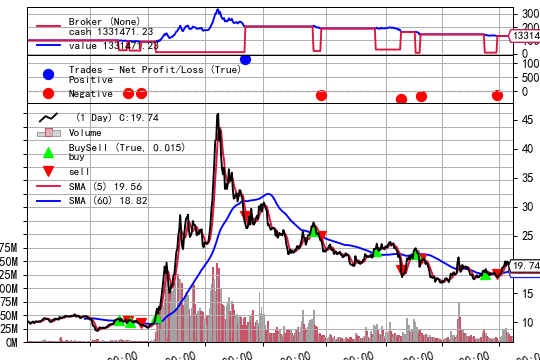

[[<Figure size 432x288 with 4 Axes>]]

In [7]:
cerebro.plot()  # 画图